In [3]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import zCurve as z 
from hilbertcurve.hilbertcurve import HilbertCurve

### Functions and classes

In [4]:
# Util functions and classes
def addSeconds(seconds):
    return seconds * 1000000

def tsToSecond(startTS, currentTS):
    currentTS -= startTS
    return currentTS/1000000

def readSingleCSV(file):
    df = pd.read_csv('../../SnowFox-Roundabout-Dataset/'+file, sep=";", index_col=False)
    df['ts'] = (df['sampleTimeStamp.seconds']*1000000)+df['sampleTimeStamp.microseconds']
    df.drop(columns=['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds'], inplace=True)
    df.drop(columns=['sent.seconds', 'sent.microseconds', 'received.seconds', 'received.microseconds'], inplace=True)
    df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

    return df

def lowerPercent(percent, value):
    percent = percent/100
    lower = 1 - percent
    return value * lower

def upperPercent(percent, value):
    percent = percent/100
    upper = 1 + percent
    return value * upper

class ManipulateValues:
  def __init__(self, col, factor):
    self.col = col
    self.factor = factor

  def __str__(self):
    percentage = self.factor * 100
    if percentage >= 100:
        percentage = percentage - 100
        return '\033[96m' + 'Icreasing ' + self.col + ' by: ' + str(percentage) + '%' + '\033[0m'
    else:
        percentage = 100 - percentage
        return '\033[96m' + 'Decreasing ' + self.col + ' by: ' + str(percentage) + '%' + '\033[0m'

class Roundabout:
  def __init__(self, startTS, endTS):
    self.startTS = startTS
    self.endTS = endTS

  def __str__(self):
      return str(tsToSecond(1584853114225674, self.startTS)) + ' - ' + str(tsToSecond(1584853114225674, self.endTS))

class Centroid:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.pointsInRange = 0
    self.points = []


def generateCentroidTL(df):
    hilbRange = df['hilbert_codes'].max() - df['hilbert_codes'].min()
    tsRange = df['ts'].max() - df['ts'].min()

    cY = df['ts'].max() - (0.15 * tsRange)
    cX = df['hilbert_codes'].min() + (0.05 * hilbRange)

    centroid = Centroid(x=cX, y=cY)

    return centroid

def generateCentroidCR(df):
    hilbRange = df['hilbert_codes'].max() - df['hilbert_codes'].min()
    tsRange = df['ts'].max() - df['ts'].min()

    cY = (((df['ts'].max() - df['ts'].min()) / 2) + df['ts'].min())
    cX = df['hilbert_codes'].max() - (0.1 * hilbRange)

    centroid = Centroid(x=cX, y=cY)

    return centroid

def generateCentroidBL(df):
    hilbRange = df['hilbert_codes'].max() - df['hilbert_codes'].min()
    tsRange = df['ts'].max() - df['ts'].min()

    cY = df['ts'].min() + (0.15 * tsRange)
    cX = df['hilbert_codes'].min() + (0.05 * hilbRange)

    centroid = Centroid(x=cX, y=cY)

    return centroid

def generateCentroidDistanceTest(df, tsPercent, codePercent):
    hilbRange = df['hilbert_codes'].max() - df['hilbert_codes'].min()
    tsRange = df['ts'].max() - df['ts'].min()

    cY = df['ts'].min() + (tsPercent * tsRange)
    cX = df['hilbert_codes'].min() + (codePercent * hilbRange)

    centroid = Centroid(x=cX, y=cY)

    return centroid

In [5]:
# createSFC
# dataFRames: The data to include in the sfc, increases dimensions. Eg. [dfWheel, dfAng, dfSpeed]
# type: 'morton' or 'hilbert'
# includeTS: returns a dataframe with timestamps and morton/hilbert codes
# factorMultiply: Factor to multiply all data with, set to 1 to leave data as is
# constantOffset: Offset all data by specific amount. Set to 0 for dynamic offsetting
# controlValRanges: RQ1+RQ2 for g5, helps with asymmetric value ranges
def createSFC(dataFrames, type:str, includeTS:bool, factorMultiply:int, constantOffset:int, controlValRanges:bool, manips):

    if(type != 'morton' and type != 'hilbert'):
        print('\033[91m' + 'Error: Select \"morton\" or \"hilbert\" as type.' + '\033[0m')
        return

    if len(dataFrames) < 1:
        return

    # 0. Save timestamps data for later
    if 'ts' in dataFrames[0].columns:
        timeStamps = dataFrames[0]['ts']
    else:
        print('\033[91m' + 'Error: No timestamps to save in step 0. Maybe reload the csv data?' + '\033[0m')
        return

    # 1. Equalize number of rows
    # 1.1. Find what is the lowest number of rows
    minRows = math.inf
    for df in dataFrames:
        rows = len(df)
        if rows < minRows:
            minRows = rows
    
    # 1.2. Equaluize all dataframes
    for df in dataFrames:
        rows = len(df)
        if rows > minRows:
            diff = abs(rows - minRows)
            #print('Removing ' + str(diff) + ' from ' + df)
            df.drop(df.tail(diff).index,inplace=True)

    # 2. Find smallest value in any dataframe, also remove timestamp
    minVals = []
    for df in dataFrames:
        if 'ts' in df.columns:
            df.drop(columns=['ts'], inplace=True)
        for col in df.columns:
            minVals.append(df[col].min())

    minVal = np.min(minVals)

    # 3. Offset all dataframes, such that there are no negative
    # values and the smallest value in any dataframe will be 0
    if minVal < 0 and constantOffset == 0:
        print('Offsetting by: ' + str(minVal*-1))
        minVal*=-1
        for df in dataFrames:
            for col in df.columns:
                df[col]=df[col].add(minVal)
                # For changing value ranges
                #if col == 'IMURollRate' or col == 'IMUYawRate':
                #   df[col] = df.apply(lambda x: x[col]*10, axis=1)
    elif constantOffset > 0:
        print('Offsetting by: ' + str(constantOffset))
        for df in dataFrames:
            for col in df.columns:
                    df[col]=df[col].add(constantOffset)
    elif minVal >= 0:
        print('Minval >= 0')
       


    # (Related to RQ1+RQ2 for Group 5) Standardize value ranges
    # For each type of data in each dataframe, find greatest value.
    # All other values in the same dataframe are made to be a percentage of that value.
    # Greatest value is 1, all others 0-1
    # Multiply all values by 100, since they will be made to integers in the next step.
    if controlValRanges:
        for df in dataFrames:
            for col in df.columns:
                maxVal = df[col].max()
                df[col] = df.apply(lambda x: x[col]/maxVal, axis=1)
                df[col] = df.apply(lambda x: x[col]*100, axis=1)
        print('Done adjusting ranges')
    

    # 4. Convert all data to int, also figure out the number of dimensions here
    dimensions = 0
    print('Multiplying by: ' + str(factorMultiply))
    for df in dataFrames:
        for col in df.columns:
            df[col] = df.apply(lambda x: x[col]*factorMultiply, axis=1)

            for manip in manips:
                if col == manip.col:
                    df[col] = df.apply(lambda x: x[col]*manip.factor, axis=1)
                    print(manip.__str__())

            df[col] = df[col].astype(int)
            print('Largest value in ' + str(col) + ': ' + str(df[col].max()))
            #if df[col].max() >= sys.maxsize:
            #    print('An int in ' + col + ' is larger that the max int size')
            dimensions += 1

    #for index, df in enumerate(dataFrames):
    #    df.to_csv('func' + str(index) + '.csv')

    # 5. Concatenate dataframes
    joined = pd.concat(dataFrames, axis=1, ignore_index=False, join='inner')

    # 6. Convert to numpy array
    npa = np.array([])
    #if type == 'hilbert':
    #    npa = joined.to_numpy(dtype=float) # float works for hilbert
    #else:
    #    npa = joined.to_numpy(dtype=int)

    if type == 'morton':
        npa = joined.to_numpy(dtype=int)
    else:
        npa = joined.to_numpy(dtype=float) # float works for hilbert

    #print(npa)

    # 7. Create SFCs
    print('Dimensions: ' + str(dimensions))
    print('Shape is: ' + str(np.shape(npa)))
    print('Creating SFC...')

    if type == 'hilbert':
        # Create hilbert curve which can use numpy arrays
        hilbert = HilbertCurve(p=128, n=dimensions, n_procs=-1)
        #Get the encoded hilbert code values for each row of points. use match type to return numpy narray
        hilbert_codes = hilbert.distances_from_points(npa, match_type=True)

        if includeTS:
            # Combine SFC with the timestamp such that we can plot/visualize over time
            hilDF = pd.DataFrame(hilbert_codes)
            hts = pd.concat([hilDF, timeStamps], axis=1, ignore_index=True, join='inner')
            hts.columns = ['hilbert_codes', 'ts']
            dataT = (hts['hilbert_codes'][0])
            print('\033[94m' + 'Data type is: ' + '\033[0m' + str(dataT.__class__))
            print('\033[92m' + 'Done: Returning hilbert_codes with time_stamp' + '\033[0m')
            return hts
        else:
            dataT = (hilbert_codes[0])
            print('\033[94m' + 'Data type is: ' + '\033[0m' + str(dataT.__class__))
            print('\033[92m' + 'Done: Returning hilbert_codes' + '\033[0m')
            return hilbert_codes

    if type == 'morton':
        # Create morton curve, which cannot use numpy arrays
        npal = npa.tolist()
        morton_codes = z.par_interlace(npal, dims=dimensions, bits_per_dim=64)

        if includeTS:
            # Combine SFC with the timestamp such that we can plot/visualize over time
            morton = pd.DataFrame(morton_codes)
            mts = pd.concat([morton, timeStamps], axis=1, ignore_index=True, join='inner')
            mts.columns = ['z_codes', 'ts']
            mts['z_codes'] = mts['z_codes'].astype(float)
            dataT = (mts['z_codes'][0])
            print('\033[94m' + 'Data type is: ' + '\033[0m' + str(dataT.__class__))
            print('\033[92m' + 'Done: Returning morton_codes with time_stamp' + '\033[0m')
            return mts
        else:
            print('\033[92m' + 'Done: Returning morton_codes' + '\033[0m')
            dataT = (morton_codes[0])
            print(dataT.__class__)
            print('\033[93m' + 'Warning: Morton codes have not been cast to float. It is likely they are python int which can cause issues with plotting. Use includeTS=True to cast them or do it manually if plotting doesn\'t work' + '\033[0m')
            return morton_codes


### Create curve

In [12]:
dfSpeed = readSingleCSV('data/Speed-5Hz.csv')
dfWheel = readSingleCSV('data/SteeringWheelAngle-5Hz.csv') # SteeringWhlAngle
dfAcc = readSingleCSV('data/Vehicle-IMU-Acceleration-50Hz.csv')
dfAng = readSingleCSV('data/Vehicle-IMU-AngularVelocities-5Hz.csv') # IMURollRate;IMUYawRate
dfHeading = readSingleCSV('data/Heading-20Hz.csv')
# Read reference data
dfRefSpeed = readSingleCSV('reference-roundabout/reference-roundabout.Speed-50Hz.csv')
dfRefWheel = readSingleCSV('reference-roundabout/reference-roundabout.SteeringWheelAngle-50Hz.csv')
dfRefAcc = readSingleCSV('reference-roundabout/reference-roundabout.Vehicle-IMU-Acceleration-50Hz.csv')
dfRefAng = readSingleCSV('reference-roundabout/reference-roundabout.Vehicle-IMU-AngularVelocities-50Hz.csv')

manips = [ManipulateValues('SteeringWhlAngle', 1.0)]
# dataFrames = [dfWheel, dfSpeed] man dfs been using
dataFrames = [dfWheel, dfSpeed]
hts = createSFC(dataFrames=dataFrames, type='hilbert', includeTS=True, factorMultiply=10000, constantOffset=10, controlValRanges=True, manips=manips)

Offsetting by: 10
Done adjusting ranges
Multiplying by: 10000
Icreasing SteeringWhlAngle by: 0.0%
Largest value in SteeringWhlAngle: 1000000
Largest value in groundSpeed: 1000000
Dimensions: 2
Shape is: (16963, 2)
Creating SFC...
Data type is: <class 'numpy.float64'>
Done: Returning hilbert_codes with time_stamp


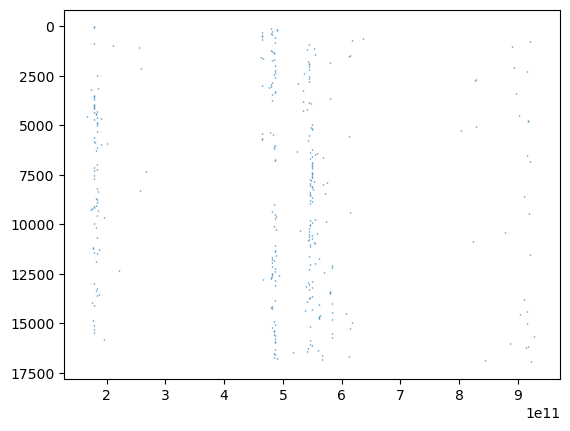

In [13]:
# Scatter plot full
df_hilbert_ts= hts.loc[:,['ts','hilbert_codes']]

df_result= df_hilbert_ts.copy()
df_demo=df_result.iloc[:,1:]
plt.gca().invert_yaxis()
plt.eventplot(df_demo.values.tolist(),orientation='horizontal',lineoffsets=1,linelengths=1,linewidths=1)
plt.show()

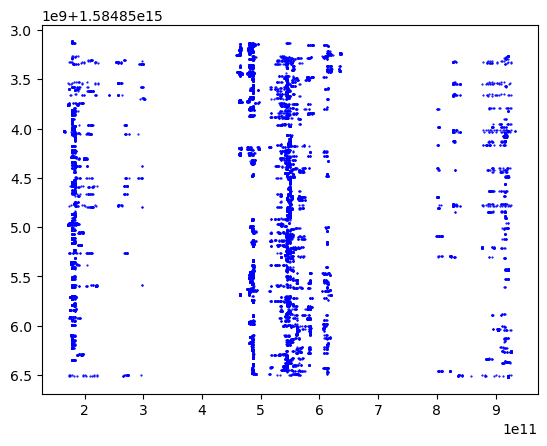

In [14]:
# Scatter plot full - blue
plt.gca().invert_yaxis()
plt.scatter(x=df_result['hilbert_codes'],y=df_result['ts'],c='blue',s=0.3)
plt.show()

In [15]:
# Section
time_stamp = df_result['ts'].min() + addSeconds(20)
dff_result = df_result[(df_result['ts'] > time_stamp) & (df_result['ts'] < time_stamp + addSeconds(35))]

Section
From 20.0s to 55.0s


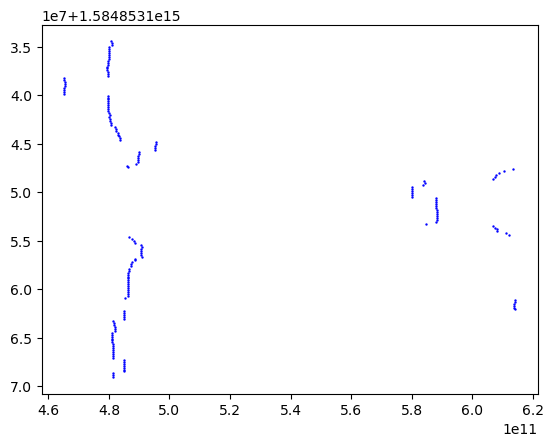

In [16]:
# Plot section
print('Section')
print('From ' + str(round(tsToSecond(df_result['ts'].min(), dff_result['ts'].min()), 0)) + 's to ' + str(round(tsToSecond(df_result['ts'].min(), dff_result['ts'].max()), 0)) + 's')
plt.gca().invert_yaxis()
plt.scatter(x=dff_result['hilbert_codes'],y=dff_result['ts'],c='blue',s=0.5)
plt.show()

20.13422818791946% of points were in TL (30)
27.516778523489933% of points were in CR (41)
22.818791946308725% of points were in BL (34)
70.46979865771812% of points were assigned a cluster
1: True
2: True
3: True
4: True
5: True
6: True


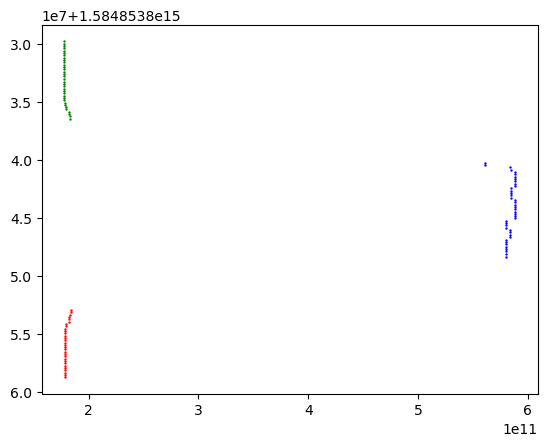

In [22]:
## Try clustering a single RB

df_to_use = dff_result

# Check if the range of values is similar to section enough
minFromSearchingSection = df_to_use['hilbert_codes'].min()
maxFromSearchingSection = df_to_use['hilbert_codes'].max()

## This is used to check if the value range is large enough, for example: the found RB goes from 2 - 6 in code values.
# Problem is that the reference run only goes from 4-6 which would not allow this to detect
#if minFromSearchingSection * maxMagnitudeOfMinSmaller > maxFromSearchingSection:
#    continue

centroidTL = generateCentroidTL(df_to_use)
centroidCR = generateCentroidCR(df_to_use)
centroidBL = generateCentroidBL(df_to_use)

centroids = [centroidTL, centroidCR, centroidBL]

#maxDistanceX = 219181973273 * 1.0 # Codes
maxDistanceY = 4195933 * 1.0 # Time

hilbRangeCluster = df_to_use['hilbert_codes'].max() - df_to_use['hilbert_codes'].min()
tsRangeCluster = df_to_use['ts'].max() - df_to_use['ts'].min()

maxDistanceX = hilbRangeCluster * 0.35
#maxDistanceY = 4195933

#print('MaxX: ' + str(maxDistanceX))
#print('MaxY: ' + str(maxDistanceY))

#print('MaxX: ' + str(219181973273 > maxDistanceX))
#print('MaxY: ' + str(4195933 > maxDistanceY))

for i in range(len(df_to_use)):
    #leastDistance = np.inf
    pt = df_to_use.iloc[i,:]
    cCentroidIndex = -1

    for i in range(len(centroids)):
        ptX = pt['hilbert_codes']
        ptY = pt['ts']

        cX = centroids[i].x
        cY = centroids[i].y

        xDistance = abs(cX - ptX)
        yDistance = abs(cY - ptY)

        #maxDistanceX = 0.1 * cX
        #maxDistanceY = 0.1 * cY

        if xDistance < maxDistanceX and yDistance < maxDistanceY:
            cCentroidIndex = i
            break

        #if distance < leastDistance:
        #    leastDistance = distance
        #    cCentroidIndex = i

    if cCentroidIndex >= 0:
        centroids[cCentroidIndex].pointsInRange += 1
        centroids[cCentroidIndex].points.append(pt)


#for j in range(len(centroids)):
    #print('Centroid ' + str(j) + ' had ' + str(centroids[j].pointsInRange))

    #npppa = np.array(centroids[j].points)
    #print(npppa)

    #colors = ['red', 'blue', 'green']
    #plt.scatter(x=npppa[:,1],y=npppa[:,0],c=colors[j],s=0.5)

totalPointsFromStart = len(df_to_use)
totalPointsInAoI = centroidTL.pointsInRange + centroidCR.pointsInRange + centroidBL.pointsInRange

print( str((centroidTL.pointsInRange / totalPointsFromStart)*100) + '% of points were in TL (' + str(centroidTL.pointsInRange) + ')')
print( str((centroidCR.pointsInRange / totalPointsFromStart)*100) + '% of points were in CR (' + str(centroidCR.pointsInRange) + ')')
print( str((centroidBL.pointsInRange / totalPointsFromStart)*100) + '% of points were in BL (' + str(centroidBL.pointsInRange) + ')')

print( str((totalPointsInAoI / totalPointsFromStart)*100) + '% of points were assigned a cluster')

try:
    check1 = ((centroidTL.pointsInRange / totalPointsFromStart)*100) > 18
    check2 = ((centroidCR.pointsInRange / totalPointsFromStart)*100) > 20
    check3 = ((centroidBL.pointsInRange / totalPointsFromStart)*100) > 16
    check4 = ((totalPointsInAoI / totalPointsFromStart)*100) > 58
    check5 = totalPointsInAoI > 10 ####### TODO: This is exact number should probably be something else, but for now I think we can for sure say if less than 10 points then its not enough data to say rb
    check6 = minFromSearchingSection > 0 ####### TODO: No idea why but some instances of data points are negative, even though there should not be any possibility for this to happen. When plotting a graph
    # at the "found" roundabout there are no data points at all. Quite rare this happens but adding this check anyways.
except ZeroDivisionError:
    print('Division by zero')
except:
    print('Other error')

print('1: ' + str(check1))
print('2: ' + str(check2))
print('3: ' + str(check3))
print('4: ' + str(check4))
print('5: ' + str(check5))
print('6: ' + str(check6))


if check1 and check2 and check3 and check4 and check5 and check6:
    #totalFoundRB += 1
    #newRB = Roundabout(time_stamp, end_stamp)
    #rbs.append(newRB)
    #resumeAtTs = end_stamp

    for k in range(len(centroids)):
        colors = ['red', 'blue', 'green']
        #print(centroids[k].points[0]['ts'])
        numpArr = np.array(centroids[k].points)
        #print(numpArr)

        d = {'ts': [centroidTL.y, centroidCR.y, centroidBL.y], 'hilbert_codes': [centroidTL.x, centroidCR.x, centroidBL.x]}

        nc = pd.DataFrame(data=d)
        if True:
            try:
                #plt.scatter(x=nc['hilbert_codes'], y=nc['ts'], c='black', s=200, alpha=0.1)
                plt.scatter(x=numpArr[:,1], y=numpArr[:,0], c=colors[k], s=0.5)
            except IndexError:
                print('too many indices for array: array is 1-dimensional, but 2 were indexed')
                pass
            except:
                print('Something else went wrong')
                #pass

    if True:
        plt.gca().invert_yaxis()
        plt.show()

In [17]:
# Section
time_stamp = df_result['ts'].min() + addSeconds(715)
dff_result = df_result[(df_result['ts'] > time_stamp) & (df_result['ts'] < time_stamp + addSeconds(30))]

Section
From 715.0s to 745.0s


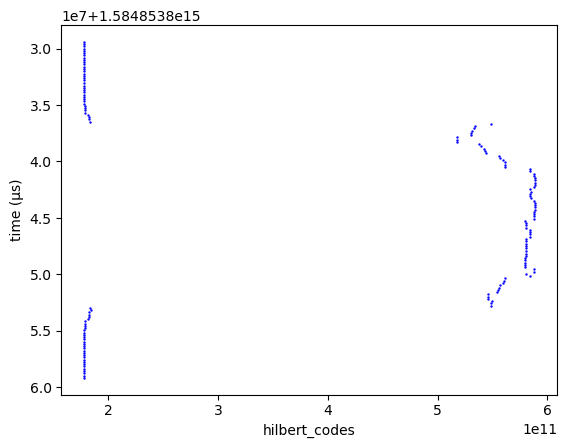

In [25]:
# Plot section
print('Section')
print('From ' + str(round(tsToSecond(df_result['ts'].min(), dff_result['ts'].min()), 0)) + 's to ' + str(round(tsToSecond(df_result['ts'].min(), dff_result['ts'].max()), 0)) + 's')
plt.gca().invert_yaxis()
plt.scatter(x=dff_result['hilbert_codes'],y=dff_result['ts'],c='blue',s=0.5, label="hilbert_codes")

plt.xlabel('hilbert_codes')
plt.ylabel('time (µs)')

#plt.legend()
image_name = './Plot-Images/HilbScatter.svg'
plt.savefig(image_name)
plt.show()

In [ ]:
## Get max and min value from sections and filter out all data larger than that, since it is most certainly not a roundabout
maxHilbertValFromSection = dff_result['hilbert_codes'].max()
minHilbertValFromSection = dff_result['hilbert_codes'].min()

## First filter out all data larger than the max (+5%)
df_filterMax = df_result[(df_result['hilbert_codes'] < maxHilbertValFromSection * 1.1)]
# Check
if False:
    plt.gca().invert_yaxis()
    plt.scatter(x=df_filterMax['hilbert_codes'],y=df_filterMax['ts'],c='blue',s=0.3)
    plt.show()

## We can do the same, but all values above min (usually arent any below this but just in case)
df_filterMin = df_filterMax[(df_result['hilbert_codes'] > minHilbertValFromSection * 0.5)]
# Check
if False:
    plt.gca().invert_yaxis()
    plt.scatter(x=df_filterMax['hilbert_codes'],y=df_filterMax['ts'],c='blue',s=0.3)
    plt.show()

# Check that section still is the same
if False:
    time_stamp = df_filterMin['ts'].min() + addSeconds(715)
    dff_filterMin = df_filterMin[(df_result['ts'] > time_stamp) & (df_filterMin['ts'] < time_stamp + addSeconds(35))]
    plt.gca().invert_yaxis()
    plt.scatter(x=dff_filterMin['hilbert_codes'],y=dff_filterMin['ts'],c='blue',s=0.5)
    plt.show()

# There is still much noise in between the max and min values, so filter this out
htsOnlyMaxAndMin = df_filterMin[(df_filterMin['hilbert_codes'] > maxHilbertValFromSection * 0.95) | (df_filterMin['hilbert_codes'] < minHilbertValFromSection * 1.2)]

# Check full plot and section again
if False:
    plt.gca().invert_yaxis()
    plt.scatter(x=htsOnlyMaxAndMin['hilbert_codes'],y=htsOnlyMaxAndMin['ts'],c='blue',s=0.3)
    plt.show()

    time_stamp = htsOnlyMaxAndMin['ts'].min() + addSeconds(715)
    dff_htsOnlyMaxAndMin = htsOnlyMaxAndMin[(htsOnlyMaxAndMin['ts'] > time_stamp) & (htsOnlyMaxAndMin['ts'] < time_stamp + addSeconds(35))]
    plt.gca().invert_yaxis()
    plt.scatter(x=dff_htsOnlyMaxAndMin['hilbert_codes'],y=dff_htsOnlyMaxAndMin['ts'],c='blue',s=0.5)
    plt.show()

# Range of values are important, something may follow the patter or be within min distance of centroids. But have very small value ranges of codes.

maxMagnitudeOfMin = maxHilbertValFromSection / minHilbertValFromSection
maxMagnitudeOfMinSmaller = maxMagnitudeOfMin * 0.8

print('Min code val: ' + str(htsOnlyMaxAndMin['hilbert_codes'].min()))
print('Max code val: ' + str(htsOnlyMaxAndMin['hilbert_codes'].max()))
print('Max is: ' + str(round(maxMagnitudeOfMin, 3)) + 'x larger than min')
print('When min is multiplied by: ' + str(round(maxMagnitudeOfMinSmaller, 3)) + ' it should still be smaller than max')
print('Length is now: ' + str(len(htsOnlyMaxAndMin)) + ', was: ' + str(len(df_result)))

Min code val: 1.999691439534999e+23
Max code val: 8.210735025564565e+23
Max is: 3.813x larger than min
When min is multiplied by: 3.051 it should still be smaller than max
Length is now: 6955, was: 16963


/var/folders/vw/2rgwl_ln6lg75qlwwlw4wzhh0000gn/T/ipykernel_75270/2183599299.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filterMin = df_filterMax[(df_result['hilbert_codes'] > minHilbertValFromSection * 0.5)]


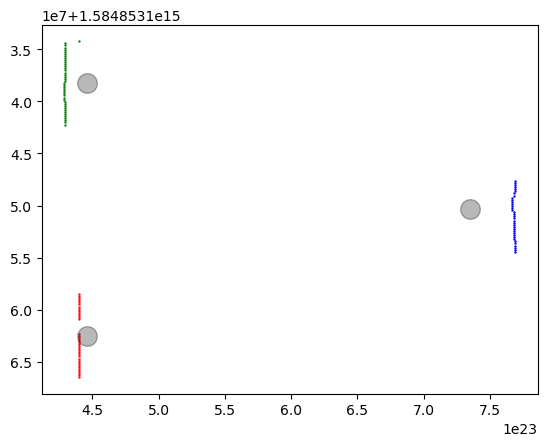

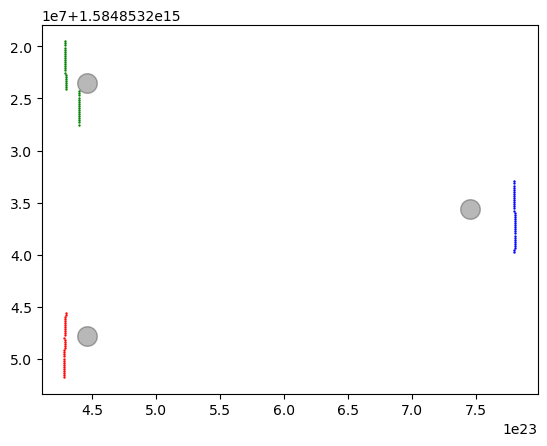

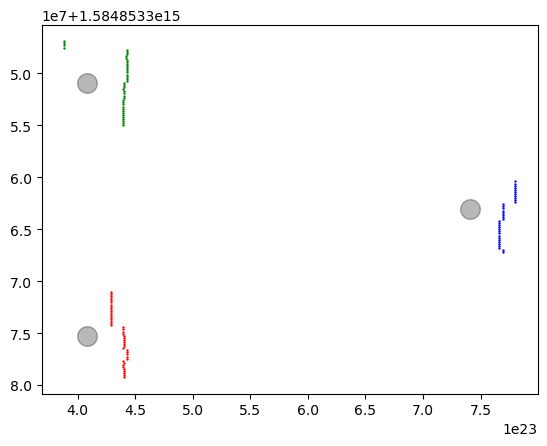

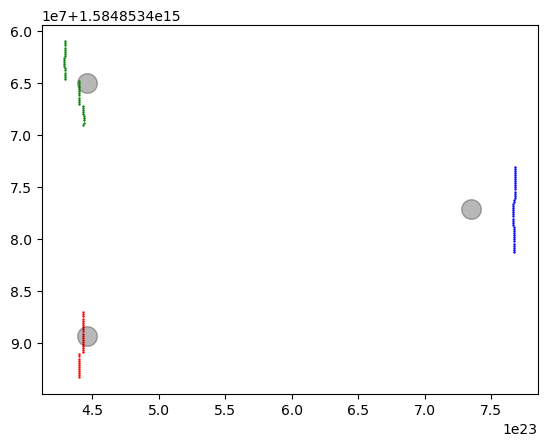

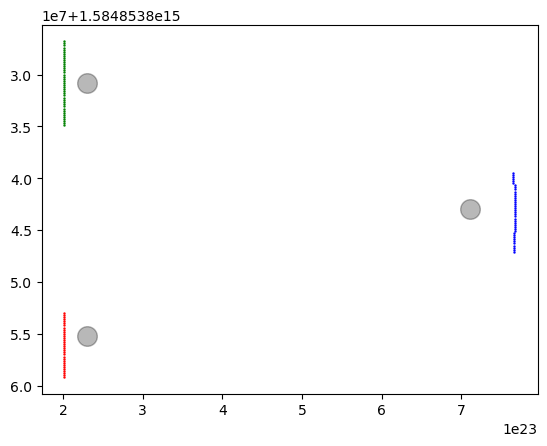

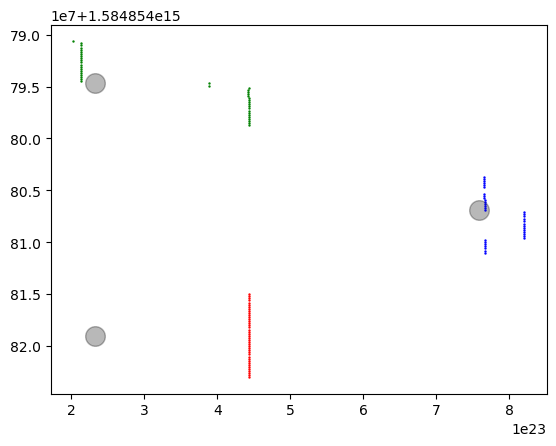

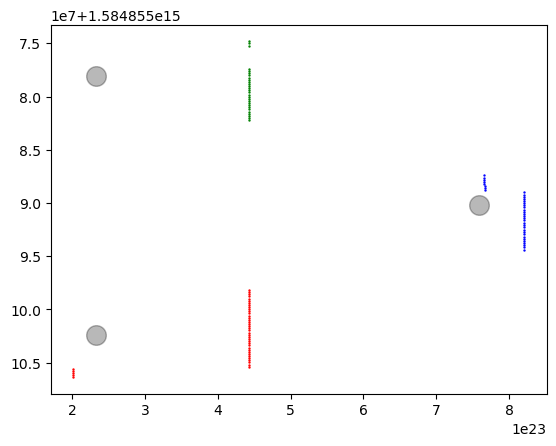

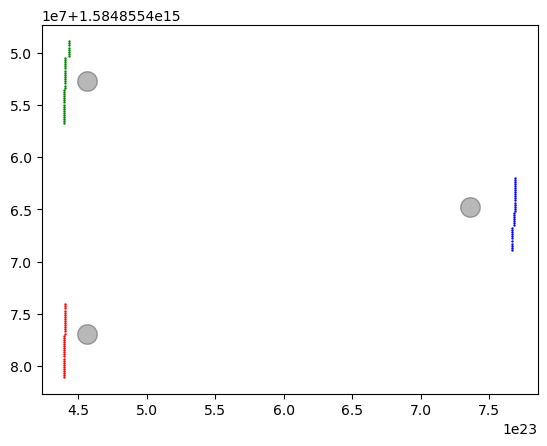

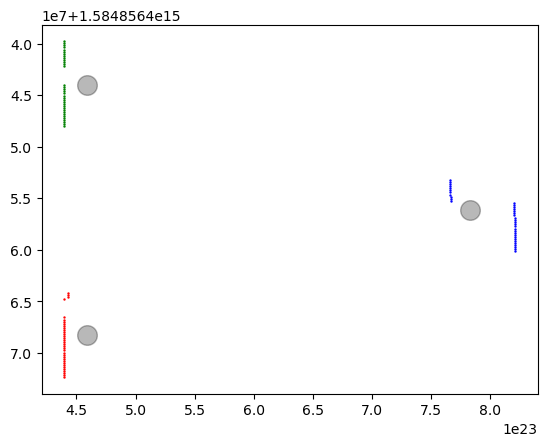

100.0% - Found: 9

Done! Found 9 roundabouts
From 19s to 54s (35s)
From 104s to 139s (35s)
From 231s to 266s (35s)
From 345s to 380s (35s)
From 711s to 746s (35s)
From 1675s to 1710s (35s)
From 1958s to 1993s (35s)
From 2333s to 2368s (35s)
From 3324s to 3359s (35s)


In [ ]:
## Finding RBs

searchingSFC = df_filterMax.copy()

#startStamp = searchingSFC['ts'].min()
#tsToSecond(startStamp, searchingSFC['ts'][i])
totalLen = len(searchingSFC)

resumeAtTs = searchingSFC['ts'].min()

totalFoundRB = 0
rbs = []

plotting = True

for i in range(totalLen):
    print(f'\r{("{0:." + str(1) + "f}").format(100 * (i / float(totalLen)))}%' + '  - Found: ' + str(totalFoundRB), end = '\r')

    # i%3 != 0, makes it only check every third time_stamp. Significantly faster and detects 1 less RB
    if searchingSFC.iloc[i,:]['ts'] < resumeAtTs:# or i%3 != 0:
        continue

    ## Check if an RB by seeing if it matches pattern
    time_stamp = searchingSFC.iloc[i,:]['ts']
    end_stamp = time_stamp + addSeconds(35)

    if end_stamp > searchingSFC['ts'].max():
        break

    df_to_use = searchingSFC[(searchingSFC['ts'] > time_stamp) & (searchingSFC['ts'] < end_stamp)]

    # Check if the range of values is similar to section enough
    minFromSearchingSection = df_to_use['hilbert_codes'].min()
    maxFromSearchingSection = df_to_use['hilbert_codes'].max()

    ## This is used to check if the value range is large enough, for example: the found RB goes from 2 - 6 in code values.
    # Problem is that the reference run only goes from 4-6 which would not allow this to detect
    #if minFromSearchingSection * maxMagnitudeOfMinSmaller > maxFromSearchingSection:
    #    continue

    centroidTL = generateCentroidTL(df_to_use)
    centroidCR = generateCentroidCR(df_to_use)
    centroidBL = generateCentroidBL(df_to_use)

    centroids = [centroidTL, centroidCR, centroidBL]

    #maxDistanceX = 219181973273 * 1.0 # Codes
    maxDistanceY = 4195933 * 1.0 # Time

    hilbRangeCluster = df_to_use['hilbert_codes'].max() - df_to_use['hilbert_codes'].min()
    tsRangeCluster = df_to_use['ts'].max() - df_to_use['ts'].min()

    maxDistanceX = hilbRangeCluster * 0.35
    #maxDistanceY = 4195933

    #print('MaxX: ' + str(maxDistanceX))
    #print('MaxY: ' + str(maxDistanceY))

    #print('MaxX: ' + str(219181973273 > maxDistanceX))
    #print('MaxY: ' + str(4195933 > maxDistanceY))

    for i in range(len(df_to_use)):
        #leastDistance = np.inf
        pt = df_to_use.iloc[i,:]
        cCentroidIndex = -1

        for i in range(len(centroids)):
            ptX = pt['hilbert_codes']
            ptY = pt['ts']

            cX = centroids[i].x
            cY = centroids[i].y

            xDistance = abs(cX - ptX)
            yDistance = abs(cY - ptY)

            #maxDistanceX = 0.1 * cX
            #maxDistanceY = 0.1 * cY

            if xDistance < maxDistanceX and yDistance < maxDistanceY:
                cCentroidIndex = i
                break

            #if distance < leastDistance:
            #    leastDistance = distance
            #    cCentroidIndex = i

        if cCentroidIndex >= 0:
            centroids[cCentroidIndex].pointsInRange += 1
            centroids[cCentroidIndex].points.append(pt)


    #for j in range(len(centroids)):
        #print('Centroid ' + str(j) + ' had ' + str(centroids[j].pointsInRange))

        #npppa = np.array(centroids[j].points)
        #print(npppa)

        #colors = ['red', 'blue', 'green']
        #plt.scatter(x=npppa[:,1],y=npppa[:,0],c=colors[j],s=0.5)

    totalPointsFromStart = len(df_to_use)
    totalPointsInAoI = centroidTL.pointsInRange + centroidCR.pointsInRange + centroidBL.pointsInRange

    #print( str((centroidTL.pointsInRange / totalPointsFromStart)*100) + '% of points were in TL (' + str(centroidTL.pointsInRange) + ')')
    #print( str((centroidCR.pointsInRange / totalPointsFromStart)*100) + '% of points were in CR (' + str(centroidCR.pointsInRange) + ')')
    #print( str((centroidBL.pointsInRange / totalPointsFromStart)*100) + '% of points were in BL (' + str(centroidBL.pointsInRange) + ')')

    #print( str((totalPointsInAoI / totalPointsFromStart)*100) + '% of points were assigned a cluster')
    
    try:
        check1 = ((centroidTL.pointsInRange / totalPointsFromStart)*100) > 18
        check2 = ((centroidCR.pointsInRange / totalPointsFromStart)*100) > 20
        check3 = ((centroidBL.pointsInRange / totalPointsFromStart)*100) > 16
        check4 = ((totalPointsInAoI / totalPointsFromStart)*100) > 58
        check5 = totalPointsInAoI > 10 ####### TODO: This is exact number should probably be something else, but for now I think we can for sure say if less than 10 points then its not enough data to say rb
        check6 = minFromSearchingSection > 0 ####### TODO: No idea why but some instances of data points are negative, even though there should not be any possibility for this to happen. When plotting a graph
        # at the "found" roundabout there are no data points at all. Quite rare this happens but adding this check anyways.
    except ZeroDivisionError:
        #print('Division by zero')
        continue
    except:
        print('Other error')
        continue


    if check1 and check2 and check3 and check4 and check5 and check6:
        totalFoundRB += 1
        newRB = Roundabout(time_stamp, end_stamp)
        rbs.append(newRB)
        resumeAtTs = end_stamp

        for k in range(len(centroids)):
            colors = ['red', 'blue', 'green']
            #print(centroids[k].points[0]['ts'])
            numpArr = np.array(centroids[k].points)
            #print(numpArr)

            d = {'ts': [centroidTL.y, centroidCR.y, centroidBL.y], 'hilbert_codes': [centroidTL.x, centroidCR.x, centroidBL.x]}

            nc = pd.DataFrame(data=d)
            if plotting:
                try:
                    plt.scatter(x=nc['hilbert_codes'], y=nc['ts'], c='black', s=200, alpha=0.1)
                    plt.scatter(x=numpArr[:,1], y=numpArr[:,0], c=colors[k], s=0.5)
                except IndexError:
                    #print('too many indices for array: array is 1-dimensional, but 2 were indexed')
                    pass
                except:
                    print('Something else went wrong')
                    #pass

        if plotting:
            plt.gca().invert_yaxis()
            plt.show()
    

print(f'\r{("{0:." + str(1) + "f}").format(100 * (1 / float(1.0)))}%', end = '\r')
print('\n')
print('\033[92m' + 'Done!'  + '\033[0m' + ' Found ' + str(totalFoundRB) + ' roundabouts')


for rb in rbs:
    strt = round(tsToSecond(searchingSFC['ts'].min(), rb.startTS), 0)
    endn = round(tsToSecond(searchingSFC['ts'].min(), rb.endTS), 0)
    duration = round(endn - strt, 0)

    print('From ' + str(int(strt)) + 's to ' + str(int(endn)) + 's (' + str(int(duration)) + 's)' )

In [ ]:
## Confirmed RBs
confirmedRBs = [
    [1584855907826492, 1584855957057419],
    [1584855801534728, 1584855834264867],
    [1584855550099753, 1584855572010558],
    [1584855456558058, 1584855474498497],
    [1584853465258107, 1584853495138141]
]
confirmedRBs.reverse()

for conf in confirmedRBs:
    strt = round(tsToSecond(df_result['ts'].min(), conf[0]), 0)
    endn = round(tsToSecond(df_result['ts'].min(), conf[1]), 0)
    duration = round(endn - strt, 0)

    print('From ' + str(int(strt)) + 's to ' + str(int(endn)) + 's (' + str(int(duration)) + 's)' )

From 351s to 381s (30s)
From 2342s to 2360s (18s)
From 2436s to 2458s (22s)
From 2687s to 2720s (33s)
From 2794s to 2843s (49s)


In [ ]:
def calculatePlotRows(numItems, columns):
    remain = numItems % columns
    numItems -= remain
    rows = numItems / columns
    rows += remain
    return rows

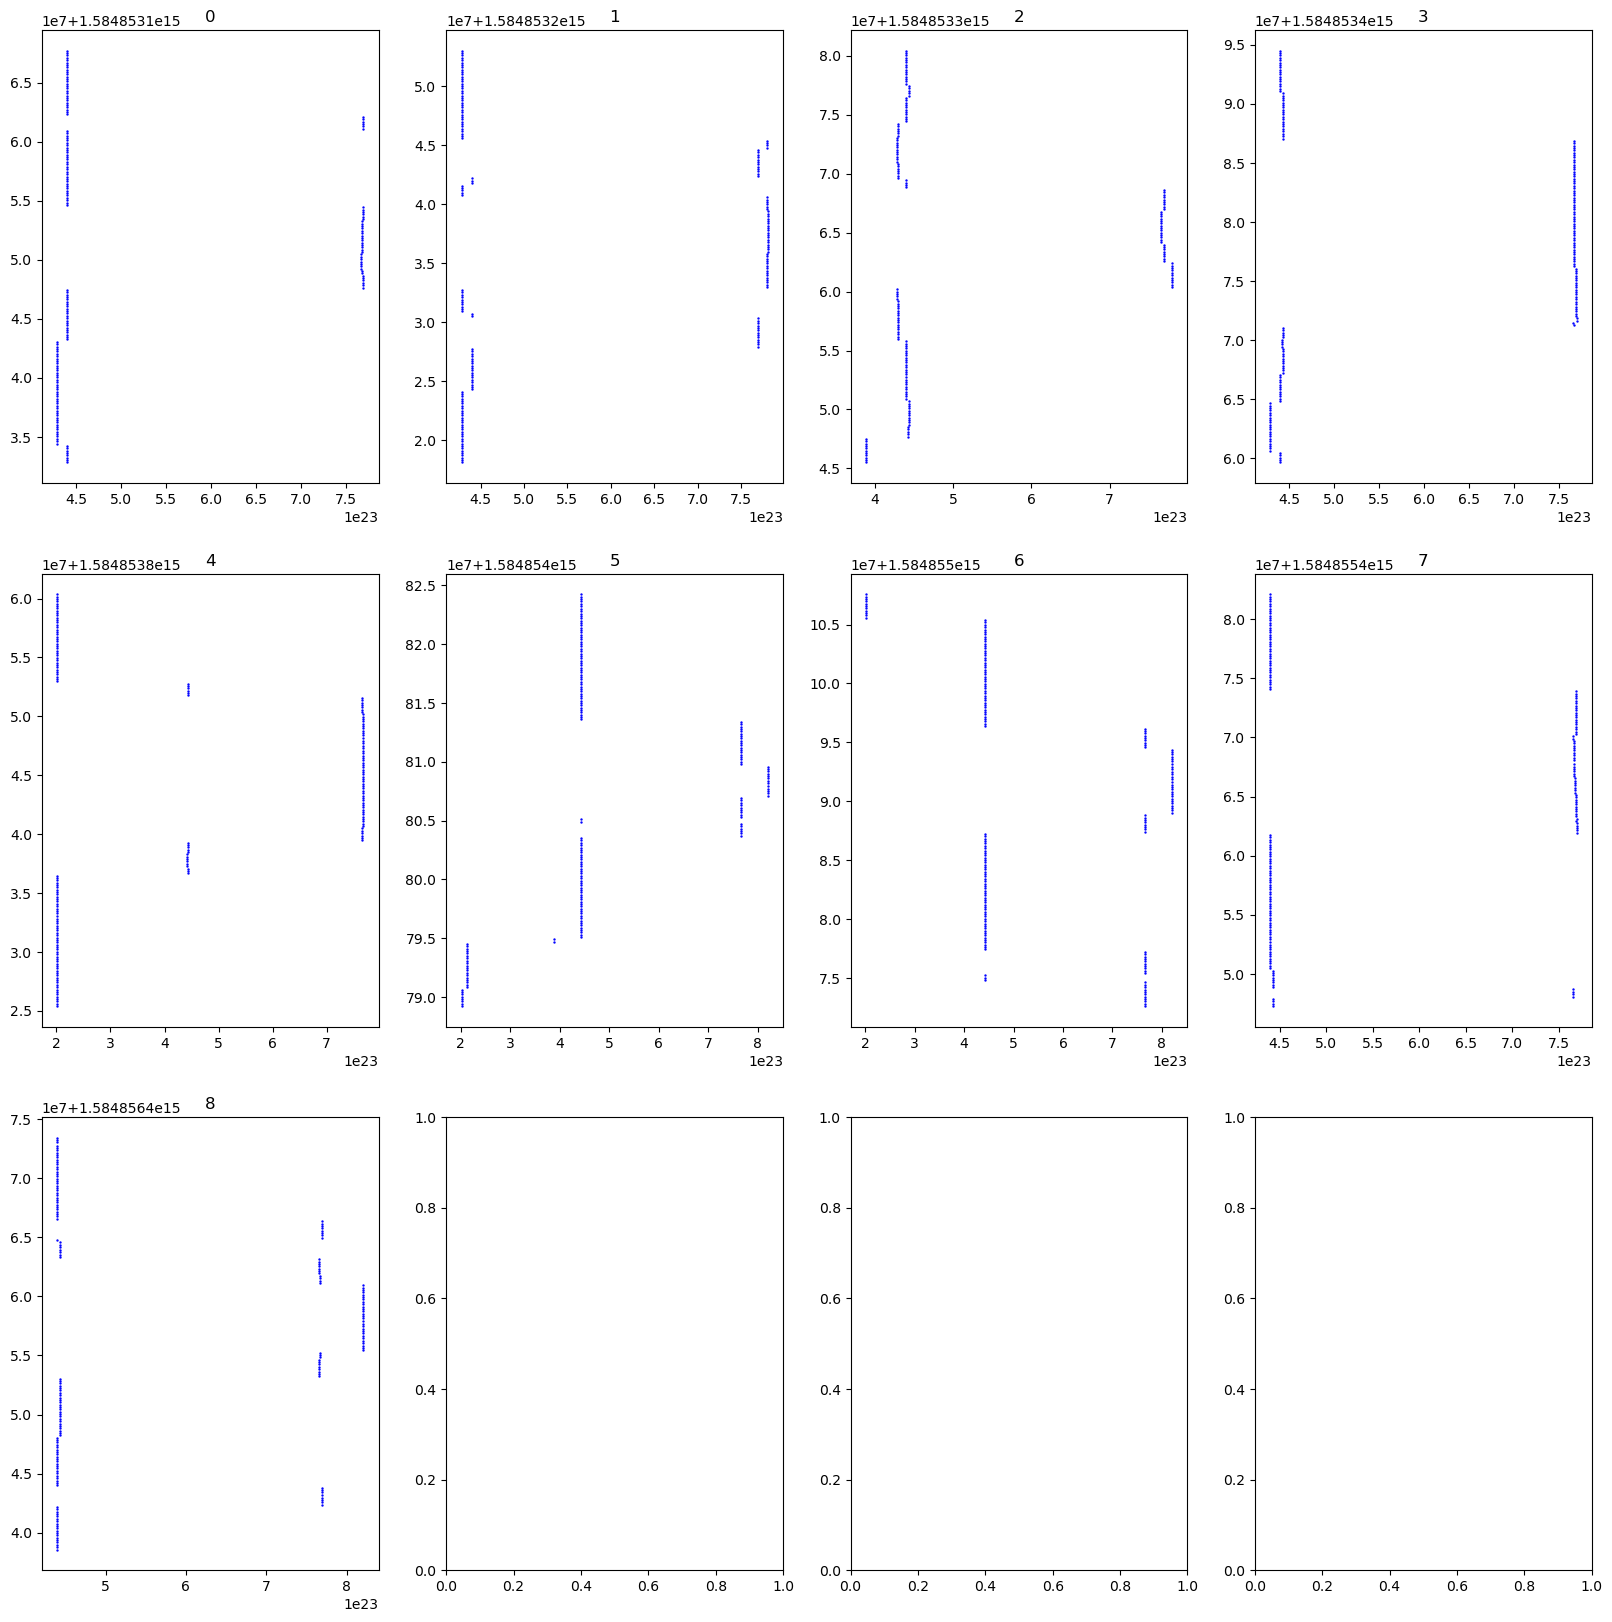

In [ ]:
# Visualize found RBs

# plot shape
pltCols = 4
pltRows = calculatePlotRows(len(rbs), pltCols)

fig, axs = plt.subplots(int(pltRows), int(pltCols))

drawClusters = False

for i in range(len(rbs)):
    potRb = searchingSFC[(searchingSFC['ts'] >= rbs[i].startTS) & (searchingSFC['ts'] <= rbs[i].endTS)]

    currentCol = i % (pltCols)
    currentRow = i / (pltCols)

    #print('currentCol: ' + str(currentCol))
    #print('currentRow: ' + str(int(currentRow)))

    if drawClusters:
        ####### DRAW CLUSTERS
        df_to_use = potRb
        centroidTL = generateCentroidTL(df_to_use)
        centroidCR = generateCentroidCR(df_to_use)
        centroidBL = generateCentroidBL(df_to_use)

        centroids = [centroidTL, centroidCR, centroidBL]
        maxDistanceX = 219181973273
        maxDistanceY = 4195933

        for i in range(len(df_to_use)):
            leastDistance = np.inf
            pt = df_to_use.iloc[i,:]
            cCentroidIndex = -1

            for i in range(len(centroids)):
                ptX = pt['hilbert_codes']
                ptY = pt['ts']

                cX = centroids[i].x
                cY = centroids[i].y

                xDistance = abs(cX - ptX)
                yDistance = abs(cY - ptY)

                if xDistance < maxDistanceX and yDistance < maxDistanceY:
                    cCentroidIndex = i
                    break

                #if distance < leastDistance:
                #    leastDistance = distance
                #    cCentroidIndex = i

            if cCentroidIndex >= 0:
                centroids[cCentroidIndex].pointsInRange += 1
                centroids[cCentroidIndex].points.append(pt)


        for j in range(len(centroids)):
            #print('Centroid ' + str(j) + ' had ' + str(centroids[j].pointsInRange))

            npppa = np.array(centroids[j].points)
            #print(npppa)

            d = {'ts': [centroidTL.y, centroidCR.y, centroidBL.y], 'hilbert_codes': [centroidTL.x, centroidCR.x, centroidBL.x]}
            nc = pd.DataFrame(data=d)

            colors = ['red', 'blue', 'green']
            try:
                axs[int(currentRow), int(currentCol)].scatter(x=nc['ts'], y=nc['hilbert_codes'], c='black', s=200, alpha=0.5)
                axs[int(currentRow), int(currentCol)].scatter(x=npppa[:,0],y=npppa[:,1],c=colors[j],s=0.5)
            except:
                print("An exception occurred")

                #    (x=nc['hilbert_codes'], y=nc['ts'], c='black', s=200, alpha=0.5)
                #    plt.scatter(x=numpArr[:,1], y=numpArr[:,0], c=colors[k], s=0.5)

        totalPointsFromStart = len(df_to_use)
        totalPointsInAoI = centroidTL.pointsInRange + centroidCR.pointsInRange + centroidBL.pointsInRange

        #print( str(round((centroidTL.pointsInRange / totalPointsFromStart)*100, 1)) + '% of points were in TL (' + str(centroidTL.pointsInRange) + ')')
        #print( str(round((centroidCR.pointsInRange / totalPointsFromStart)*100, 1)) + '% of points were in CR (' + str(centroidCR.pointsInRange) + ')')
        #print( str(round((centroidBL.pointsInRange / totalPointsFromStart)*100, 1)) + '% of points were in BL (' + str(centroidBL.pointsInRange) + ')')

        #print( str(round((totalPointsInAoI / totalPointsFromStart)*100, 1)) + '% of points were assigned a cluster')

        percentTL = str(round((centroidTL.pointsInRange / totalPointsFromStart)*100, 1)) + ' '
        percentCR = str(round((centroidCR.pointsInRange / totalPointsFromStart)*100, 1)) + ' '
        percentBL = str(round((centroidBL.pointsInRange / totalPointsFromStart)*100, 1)) + ' '
        percentTotal = str(round((totalPointsInAoI / totalPointsFromStart)*100, 1)) + ' '

        ttl = str(i) + ': ' + percentTL + percentCR + percentBL + percentTotal
        axs[int(currentRow), int(currentCol)].set_title(ttl)

        ####### END DRAW CLUSTERS

    if not drawClusters:
        axs[int(currentRow), int(currentCol)].scatter(x=potRb['hilbert_codes'],y=potRb['ts'],c='blue',s=0.5)
        ####axs[int(currentRow), int(currentCol)].set_title('Axis [' + str(currentCol) + ', ' + str(currentRow) + ']')
        axs[int(currentRow), int(currentCol)].set_title(str(i))

for ax in axs.flat:
    ax.set(xlabel='', ylabel='')

#for ax in axs.flat:
#    ax.label_outer()

fig.set_figwidth(20)
fig.set_figheight(20)

#     axs[int(currentCol), int(currentRow)].scatter(x=potRb['hilbert_codes'],y=potRb['ts'],c='blue',s=0.5)
#    axs[int(currentCol), int(currentRow)].set_title('Axis [' + str(currentCol) + ', ' + str(currentRow) + ']')